# BigQuery ML (BQML) - Generative AI With SQL

BigQuery is a the home for data.  It's native language is SQL.  You can also interact with it through a Pandas like API called BigFrames.  One of the best parts about BigQuery is the vast number of functions and capabilities that allow you to do workflows directly in BigQuery without ever exporting the data out.  Like Generative AI!

This workflow shows how to reference [Vertex AI hosted foundation models](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/models) through the [ML.GENERATE_TEXT function](https://cloud.google.com/bigquery/docs/generate-text).  It will cover the setup and usage for multiple use cases as examples for getting started in your own environment.  These examples are meant to reflect common scenarios you might face in real-world application like:
- in-place generation of text using BigQuery DDL [ALTER TABLE](https://cloud.google.com/bigquery/docs/reference/standard-sql/data-definition-language#alter_table_add_column_statement) and DML [UPDATE](https://cloud.google.com/bigquery/docs/reference/standard-sql/dml-syntax#update_statement) statements
- Generating few-shot prompts from samples and applying them to larger tables
- Combining text across rows into prompts with `CONCAT`, `STRING_AGG` and `GROUP BY`

These examples cover common actual tasks.  Before getting started it may be helpful to review some of the blogs, tutorials, and demonstrations from these links:
- [Generate text by using a remote model and the ML.GENERATE_TEXT function](https://cloud.google.com/bigquery/docs/generate-text-tutorial)
- [Generate text by using the ML.GENERATE_TEXT function](https://cloud.google.com/bigquery/docs/generate-text)
- [Harnessing the power of PaLM in BigQuery](https://cloud.google.com/blog/products/data-analytics/integrating-vertex-ai-foundation-models-in-bigquery)

**BigQuery ML (BQML) Overview**

[BigQuery ML](https://cloud.google.com/bigquery/docs/bqml-introduction) allows you to use `SQL` to constuct an ML workflow.  This is a great leap in productivity and flexibility when the data source is [BigQuery](https://cloud.google.com/bigquery/docs/introduction) and users are already familiar with `SQL`. Using just `SQL`, [multiple techniques](https://cloud.google.com/bigquery/docs/bqml-introduction#model_selection_guide) can be used for model training and even include [hyperparameter tuning](https://cloud.google.com/bigquery/docs/hp-tuning-overview).  It includes serverless [training, evaluation, and inference](https://cloud.google.com/bigquery/docs/e2e-journey) techniques for supervised, unsupervised, time series methods, even recommendation engines.  [Predictions](https://cloud.google.com/bigquery/docs/inference-overview) can be served directly in BigQuery which also include explainability measures. Predictive models can be [exported to their native framework](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-export-model) for portability, or even directly [registered to Vertex AI model registry](https://cloud.google.com/bigquery/docs/create_vertex) for online predictions on Vertex AI Endpoints.  You can [import models into BigQuery ML](https://cloud.google.com/bigquery/docs/inference-overview#inference_using_imported_models) from many common frameworks, or [connect to remotely hosted models](https://cloud.google.com/bigquery/docs/inference-overview#inference_using_remote_models) on Vertex AI Endpoints. You can even directly use many [pre-trained models](https://cloud.google.com/bigquery/docs/inference-overview#pretrained-models) in Vertex AI Like Cloud Vision API, Cloud Natural Language API, Cloud Translate API, and Generative AI with Vertex AI hosted LLMs.

A great starting point for seeing the scope of available methods is the [user journey for models](https://cloud.google.com/bigquery/docs/e2e-journey).  This repository also has a series of notebook based workflows for many BigQuery ML methods that can be reviewed here: [../03 - BigQuery ML (BQML)](../03%20-%20BigQuery%20ML%20(BQML)/readme.md).

**BigFrames Overview**

A new way to interact with BigQuery and BigQuery ML is [BigQuery DataFrames](https://cloud.google.com/python/docs/reference/bigframes/latest).  A new Pythonic DataFrame with modules for BigQuery (`bigframes.pandas`) that is pandas-compatible and BigQuery ML (`bigframes.ml`) that is scikit-learn like.  This series of notebooks will be expanded to offer workflow examples in the choice of SQL or BigFrames!

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/03%20-%20BigQuery%20ML%20(BQML)/BQML%20For%20Generative%20AI%20With%20SQL.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs and API Enablement

The clients packages may need installing in this environment.

### Installs (If Needed)

In [1]:
# tuples of (import name, install name)
packages = [
    ('google.cloud.bigquery', 'google-cloud-bigquery')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### API Enablement

In [3]:
!gcloud services enable bigqueryconnection.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [4]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Setup

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
SERIES = 'bqml'
EXPERIMENT = 'genai-sql'

In [3]:
# make this the BQ Project / Dataset / Table prefix to store results
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT
BQ_REGION = REGION[0:2] # subset to first two characters for multi-region

In [4]:
from google.cloud import bigquery
from google.cloud import bigquery_connection_v1 as bq_connection

In [5]:
bq = bigquery.Client(project = PROJECT_ID)

---
## Create A BigQuery Dataset

This workflow will make a copy of a BigQuery public dataset and works with the copy.  It will use the dataset defined by the `BQ_PROJECT` and `BQ_DATASET` parameters defined above.  The following code checks for the existance of the dataset, and if needed creates it:

In [105]:
try:
    ds = bq.get_dataset(f'{BQ_PROJECT}.{BQ_DATASET}')
    print('Found the BigQuery Dataset: ', ds.full_dataset_id)
except:
    ds = bigquery.DatasetReference(BQ_PROJECT, BQ_DATASET)
    ds.location = BQ_REGION
    ds.labels = {'series': f'{SERIES}'}
    ds = bq.create_dataset(dataset = ds, exists_ok = True)
    print('Created the BigQuery Dataset: ', ds.full_dataset_id)

Found the BigQuery Dataset:  statmike-mlops-349915:bqml


---
## BigQuery ML: Connect To Vertex AI LLMs with ML.GENERATE_TEXT

BigQuery ML can `Create Model`'s that are actually connections to Remote Models. [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-remote-model)

Using the `REMOTE_SERVICE_TYPE = "CLOUD_AI_LARGE_LANGUAGE_MODEL_V1"` option will link to LLMs in Vertex AI.
- [Documentation](https://cloud.google.com/bigquery/docs/inference-overview#generative_ai)
- Specifically, it connects to [Vertex AI Foundation Models](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/models#foundation_models):
    - [ML.GENERATE_TEXT()](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-generate-text) uses the model to connect to Vertex AI `text-bision`
    - and [ML.GENERATE_TEXT_EMBEDDING()](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-generate-text-embedding) uses the model to connect to Vertex AI `textembedding-gecko`


### Connection Requirement

To make a remote connection using BigQuery ML, BigQuery uses a CLOUD_RESOURCE connection. [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-remote-model#connection)

Create a new connection with type `CLOUD_RESOURCE`: First, check for existing connection.

In [6]:
try:
    response = bq_connection.ConnectionServiceClient().get_connection(
            request = bq_connection.GetConnectionRequest(
                name = f"projects/{BQ_PROJECT}/locations/{BQ_REGION}/connections/{SERIES}_{EXPERIMENT}"
            )
    )
    print(f'Found existing connection with service account: {response.cloud_resource.service_account_id}')
    service_account = response.cloud_resource.service_account_id
except Exception:
    request = bq_connection.CreateConnectionRequest(
        {
            "parent": f"projects/{BQ_PROJECT}/locations/{BQ_REGION}",
            "connection_id": f"{SERIES}_{EXPERIMENT}",
            "connection": bq_connection.types.Connection(
                {
                    "friendly_name": f"{SERIES}_{EXPERIMENT}",
                    "cloud_resource": bq_connection.CloudResourceProperties({})
                }
            )
        }
    )
    response = bq_connection.ConnectionServiceClient().create_connection(request)
    print(f'Created new connection with service account: {response.cloud_resource.service_account_id}')
    service_account = response.cloud_resource.service_account_id

Created new connection with service account: bqcx-1026793852137-bmph@gcp-sa-bigquery-condel.iam.gserviceaccount.com


Assign the service account the Vertex AI User role:

In [7]:
!gcloud projects add-iam-policy-binding {BQ_PROJECT} --member=serviceAccount:{service_account} --role=roles/aiplatform.user

Updated IAM policy for project [statmike-mlops-349915].
bindings:
- members:
  - serviceAccount:service-1026793852137@gcp-sa-aiplatform-cc.iam.gserviceaccount.com
  role: roles/aiplatform.customCodeServiceAgent
- members:
  - serviceAccount:service-1026793852137@gcp-sa-aiplatform-vm.iam.gserviceaccount.com
  role: roles/aiplatform.notebookServiceAgent
- members:
  - serviceAccount:service-1026793852137@gcp-sa-aiplatform.iam.gserviceaccount.com
  role: roles/aiplatform.serviceAgent
- members:
  - serviceAccount:bqcx-1026793852137-bmph@gcp-sa-bigquery-condel.iam.gserviceaccount.com
  - serviceAccount:bqcx-1026793852137-dyw1@gcp-sa-bigquery-condel.iam.gserviceaccount.com
  - serviceAccount:bqcx-1026793852137-pdxa@gcp-sa-bigquery-condel.iam.gserviceaccount.com
  - serviceAccount:bqcx-1026793852137-tqpc@gcp-sa-bigquery-condel.iam.gserviceaccount.com
  - serviceAccount:bqcx-1026793852137-zfly@gcp-sa-bigquery-condel.iam.gserviceaccount.com
  role: roles/aiplatform.user
- members:
  - serviceA

### Create The Remote Model In BigQuery

In [8]:
# Create Remote Model In BigQuery
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_MODEL`
    REMOTE WITH CONNECTION `{BQ_PROJECT}.{BQ_REGION}.{SERIES}_{EXPERIMENT}`
    OPTIONS(REMOTE_SERVICE_TYPE = 'CLOUD_AI_LARGE_LANGUAGE_MODEL_V1')
"""
job = bq.query(query = query)
job.result()
job.state

'DONE'

---
## Generative AI With BQML: Simple Query

How?  Just use the [ML.GENERATE_TEXT](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-generate-text) function!

In [85]:
query = f'''
SELECT *
FROM ML.GENERATE_TEXT(
    MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_MODEL`,
    (
        SELECT "What is BigQuery ML?" AS prompt
    ),
    STRUCT(500 AS max_output_tokens, TRUE AS flatten_json_output)
)

'''
results = bq.query(query = query).to_dataframe()
results

,ml_generate_text_llm_result,ml_generate_text_rai_result,ml_generate_text_status,prompt
0,BigQuery ML is a fully managed machine learni...,"{""blocked"":false,""categories"":[],""scores"":[]}",,What is BigQuery ML?


In [29]:
print(results['prompt'].iloc[0])

What is BigQuery ML?


In [30]:
print(results['ml_generate_text_llm_result'].iloc[0])

 BigQuery ML is a fully managed machine learning service that enables businesses to build and deploy machine learning models quickly and easily. It offers a wide range of pre-trained models and allows users to create and train their own models using SQL. BigQuery ML also provides an integrated environment for developing, testing, and deploying machine learning models.


---
## Generative AI With BQML:  Generate Text For Every Row

Since ML.GENERATE_TEXT is a SQL function in BigQuery it can be applied to every value and return results for each row.

The BigQuery Public Dataset Table:  `bigquery-public-data.bbc_news.fulltext`
- has full text of articles from BBC news

This Workflow:
- reviews the data
- pulls sample articles from each `category`
- Generates a new title for each article in the sample

### Review The Data

In [31]:
query = f'''
SELECT *
FROM `bigquery-public-data.bbc_news.fulltext`
LIMIT 1
'''
results = bq.query(query = query).to_dataframe()
results

,body,title,filename,category
0,The global web blog community is being called ...,Global blogger action day called,bbc/tech/016.txt,tech


In [32]:
for col in results.columns:
    print(f'{col}:\n', results[col].iloc[0])

body:
 The global web blog community is being called into action to lend support to two imprisoned Iranian bloggers.

The month-old Committee to Protect Bloggers' is asking those with blogs to dedicate their sites on 22 February to the "Free Mojtaba and Arash Day". Arash Sigarchi and Mojtaba Saminejad are both in prison in Iran. Blogs are free sites through which people publish thoughts and opinions. Iranian authorities have been clamping down on prominent sites for some time. "I hope this day will focus people," Curt Hopkins, director of the Committee, told the BBC News website.

The group has a list of actions which it says bloggers can take, including writing to local Iranian embassies. The Committee has deemed Tuesday "Free Mojtaba and Arash Day" as part of its first campaign. It is calling on the blogsphere - the name for the worldwide community of bloggers - to do what it can to help raise awareness of the plight of Mojtaba and Arash as well as other "cyber-dissidents". "If you h

### Retrieve A Sample Including All Categories

Get up to 5 examples from each `category`.

In [106]:
query = f'''
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_sample` AS
WITH
    sample AS (
        SELECT *,
            ROW_NUMBER() OVER (PARTITION BY category ORDER BY filename) AS sequence
        FROM `bigquery-public-data.bbc_news.fulltext`
    )
SELECT * EXCEPT(sequence)
FROM sample
WHERE sequence <= 5
ORDER BY category;

SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_sample`;
'''
sample = bq.query(query = query).to_dataframe()

In [108]:
sample.groupby(['category'])['category'].count()

category
business         5
entertainment    5
politics         5
sport            5
tech             5
Name: category, dtype: int64

### Generate A New Title For Each Article - In Place

Add the column `new_title` to the table and then generate a new title that is used to update `new_title`.  

For this, combine the ML.GENERATE_TEXT function with BigQuery DDL [ALTER TABLE](https://cloud.google.com/bigquery/docs/reference/standard-sql/data-definition-language#alter_table_add_column_statement) and DML [UPDATE](https://cloud.google.com/bigquery/docs/reference/standard-sql/dml-syntax#update_statement) statements.

In [109]:
query = f'''
ALTER TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_sample`
ADD COLUMN IF NOT EXISTS new_title STRING;

UPDATE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_sample` as target
SET new_title = (
    SELECT
        IF(
            ml_generate_text_llm_result != "",
            ml_generate_text_llm_result,
            CONCAT("blocked:", JSON_VALUE(ml_generate_text_rai_result, '$.blocked'))
        ) as new_title
    FROM ML.GENERATE_TEXT(
        MODEL`{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_MODEL`,
        (
            SELECT CONCAT(
                    """The current title of an article is: """, source.title,
                    """\n\nThe body of the article is: """, source.body,
                    """\n\nThe category of the article has name: """, source.category,
                    """\n\nWhat is a better title for this article? The answer should be in english only."""
                ) as prompt
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_sample` AS source
            WHERE target.filename = source.filename
        ),
        STRUCT(200 AS max_output_tokens, TRUE AS flatten_json_output)
    )
)
WHERE true;

SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_sample`;
'''
sample = bq.query(query = query).to_dataframe()

In [110]:
for s in sample[['title', 'new_title']].values.tolist():
    print(s)

['Ink helps drive democracy in Asia', ' Kyrgyz Voters to be Ink-Marked for Elections']
['China net cafe culture crackdown', 'blocked:true']
['Microsoft seeking spyware trojan', ' Microsoft investigates spyware trojan']
['Technology gets the creative bug', ' Technology and the creative industries: a new partnership']
['Digital guru floats sub-$100 PC', ' One Laptop Per Child']
['IAAF launches fight against drugs', ' IAAF steps up drugs fight']
['Dibaba breaks 5,000m world record', ' Dibaba Breaks 5,000m World Record']
['Claxton hunting first major medal', ' Claxton chasing first major medal']
["O'Sullivan could run in Worlds", " O'Sullivan May Run in Worlds"]
['Greene sets sights on world title', ' Greene eyes world title']
["High fuel prices hit BA's profits", ' BA blames high fuel prices for profit drop']
['Yukos unit buyer faces loan claim', ' Yukos unit buyer faces $900m loan claim']
['Dollar gains on Greenspan speech', ' Dollar hits 3-month high on Greenspan speech']
['Pernod takeo

---
## Generative AI With BQML: Categorize Articles Using Few-Shot Prompting

In prompt design it is possible to include example of the task you want the LLM to perform.  This is called few-shot prompting.

For this tasks, we will use the samples above to create few-shot prompts for categorizing articles.  Then, we will apply the prompt to a larger sample and see how accurate it is at picking the same category as is already defined from the articles.

The workflow for this example:
- Attempts to categorize articles into known categories using few-shot prompting with titles
- Evaluates the accuracy of the categorization

There are many approaches to classification with LLM's that could be tried here:
- full text of articles in single or few-shot prompt
- partial text, maybe first paragraph, of article in single or few-shot prompt
- Tune an LLM with Vertex AI [supervised tuning](https://cloud.google.com/vertex-ai/docs/generative-ai/models/tune-models#supervised-tuning)

### Construct Few-Shot Prompt From Sample

Use [CONCAT](https://cloud.google.com/bigquery/docs/reference/standard-sql/string_functions#concat), [STRING_AGG](https://cloud.google.com/bigquery/docs/reference/standard-sql/aggregate_functions#string_agg) and [DISTINCT](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax) to construct a few-shot prompt for classification by using the sample table.

In [119]:
prompt_query = f'''
SELECT
    CONCAT(
        "Define a category for each text from the list of options.",
        """\nOptions:\n- """,
        STRING_AGG(DISTINCT category, """\n- """),
        """\n\n""",
        STRING_AGG(CONCAT("Text: ", title, """\nCategory: """, category), """\n\n""")
    ) as prompt,
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_sample`
'''
prompt = bq.query(query = query).to_dataframe()
print(prompt['prompt'].iloc[0])

Define a category for each text from the list of options.
Options:
- tech
- sport
- business
- politics
- entertainment

Text: Ink helps drive democracy in Asia
Category: tech

Text: China net cafe culture crackdown
Category: tech

Text: Microsoft seeking spyware trojan
Category: tech

Text: Technology gets the creative bug
Category: tech

Text: Digital guru floats sub-$100 PC
Category: tech

Text: IAAF launches fight against drugs
Category: sport

Text: Dibaba breaks 5,000m world record
Category: sport

Text: Claxton hunting first major medal
Category: sport

Text: O'Sullivan could run in Worlds
Category: sport

Text: Greene sets sights on world title
Category: sport

Text: High fuel prices hit BA's profits
Category: business

Text: Yukos unit buyer faces loan claim
Category: business

Text: Dollar gains on Greenspan speech
Category: business

Text: Pernod takeover talk lifts Domecq
Category: business

Text: Ad sales boost Time Warner profit
Category: business

Text: Watchdog probes e

### Use The Few-Shot Prompt and Generate Classifications For All Rows

Use the prompt created above to generate a classification for a sample of rows from the full table.  Use the `category_limiter` parameter to limit the number of rows per `category`.  Larger values will result in longer runtimes as the service works with the [query per minute limits of the foundation models](https://cloud.google.com/vertex-ai/docs/quotas#request_quotas).

In [210]:
# how many rows to classify per category
category_limiter = 20 

query = f'''
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_classification` AS
WITH
    prompt AS ({prompt_query}),
    sample AS (
        SELECT * EXCEPT(sequence)
        FROM (
            SELECT *, ROW_NUMBER() OVER (PARTITION BY category ORDER BY filename) AS sequence
            FROM `bigquery-public-data.bbc_news.fulltext`
        )
        WHERE sequence <= {category_limiter}
        ORDER BY category
    ),
    prepped AS (
        SELECT title, filename, category,
            CONCAT(prompt.prompt, """\n\nText: """, title, """\nCategory: """) as prompt
        FROM sample
        CROSS JOIN prompt
    ),
    generate AS (
        SELECT * EXCEPT(ml_generate_text_rai_result, ml_generate_text_llm_result), #ml_generate_text_status
            ml_generate_text_llm_result as new_category
        FROM ML.GENERATE_TEXT(
            MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_MODEL`,
            (
                SELECT *
                FROM prepped
            ),
            STRUCT(50 AS max_output_tokens, TRUE AS flatten_json_output)
        )
    )
SELECT * 
FROM generate;

SELECT *
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_classification`
ORDER BY category;
'''
results = bq.query(query = query).to_dataframe()

In [211]:
results

,ml_generate_text_status,title,filename,category,prompt,new_category
0,,India widens access to telecoms,bbc/business/019.txt,business,Define a category for each text from the list ...,tech
1,,High fuel prices hit BA's profits,bbc/business/004.txt,business,Define a category for each text from the list ...,business
2,,Jobs growth still slow in the US,bbc/business/007.txt,business,Define a category for each text from the list ...,business
3,,China keeps tight rein on credit,bbc/business/016.txt,business,Define a category for each text from the list ...,business
4,,India's rupee hits five-year high,bbc/business/018.txt,business,Define a category for each text from the list ...,business
...,...,...,...,...,...,...
95,,Virus poses as Christmas e-mail,bbc/tech/008.txt,tech,Define a category for each text from the list ...,tech
96,,Microsoft seeking spyware trojan,bbc/tech/003.txt,tech,Define a category for each text from the list ...,tech
97,,Wi-fi web reaches farmers in Peru,bbc/tech/006.txt,tech,Define a category for each text from the list ...,tech
98,,Global blogger action day called,bbc/tech/016.txt,tech,Define a category for each text from the list ...,entertainment


### Evaluate The Accuracy Of The Classification

For this use [scikit-learn](https://scikit-learn.org/stable/index.html) metrics [fuctions](https://scikit-learn.org/stable/modules/model_evaluation.html) to do model evaluation.

In [213]:
from sklearn import metrics

Cleaning The `results`:
- Remove records that did not generate responses due to "RESOURCE_EXHAUSTED error occurred."
- remove leading and trailing blanks from thegenerated responses in `new_category`

In [214]:
results[results['ml_generate_text_status'] == 'RESOURCE_EXHAUSTED error occurred.']#.shape

,ml_generate_text_status,title,filename,category,prompt,new_category
20,RESOURCE_EXHAUSTED error occurred.,Levy tipped for Whitbread prize,bbc/entertainment/007.txt,entertainment,Define a category for each text from the list ...,None
21,RESOURCE_EXHAUSTED error occurred.,Jarre joins fairytale celebration,bbc/entertainment/002.txt,entertainment,Define a category for each text from the list ...,None
22,RESOURCE_EXHAUSTED error occurred.,West End to honour finest shows,bbc/entertainment/008.txt,entertainment,Define a category for each text from the list ...,None
23,RESOURCE_EXHAUSTED error occurred.,Poppins musical gets flying start,bbc/entertainment/005.txt,entertainment,Define a category for each text from the list ...,None
24,RESOURCE_EXHAUSTED error occurred.,Uganda bans Vagina Monologues,bbc/entertainment/010.txt,entertainment,Define a category for each text from the list ...,None
80,RESOURCE_EXHAUSTED error occurred.,Intel unveils laser breakthrough,bbc/tech/019.txt,tech,Define a category for each text from the list ...,None
81,RESOURCE_EXHAUSTED error occurred.,UK net users leading TV downloads,bbc/tech/011.txt,tech,Define a category for each text from the list ...,None
82,RESOURCE_EXHAUSTED error occurred.,Apple laptop is 'greatest gadget',bbc/tech/009.txt,tech,Define a category for each text from the list ...,None
83,RESOURCE_EXHAUSTED error occurred.,EU software patent law faces axe,bbc/tech/014.txt,tech,Define a category for each text from the list ...,None
84,RESOURCE_EXHAUSTED error occurred.,IBM puts cash behind Linux push,bbc/tech/012.txt,tech,Define a category for each text from the list ...,None


In [215]:
results = results[results['ml_generate_text_status'] != 'RESOURCE_EXHAUSTED error occurred.']
known = [result.strip() for result in results['category'].values.tolist()]
predicted = [result.strip() for result in results['new_category'].values.tolist()]
labels = list(set(known))

In [216]:
labels

['entertainment', 'tech', 'politics', 'business', 'sport']

In [217]:
metrics.confusion_matrix(known, predicted, labels = labels)

array([[15,  0,  0,  0,  0],
       [ 1, 11,  0,  0,  0],
       [ 4,  0, 15,  0,  0],
       [ 2,  1,  1, 16,  0],
       [ 0,  0,  0,  0, 20]])

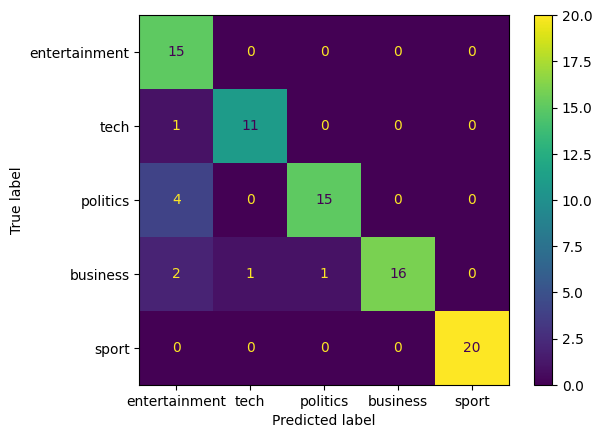

In [218]:
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(known, predicted, labels = labels),
    display_labels = labels
)
disp.plot()

In [219]:
metrics.accuracy_score(known, predicted)

0.875

In [221]:
print(metrics.classification_report(known, predicted, labels = labels))

               precision    recall  f1-score   support

entertainment       0.68      1.00      0.81        15
         tech       0.92      0.85      0.88        13
     politics       0.94      0.75      0.83        20
     business       1.00      0.80      0.89        20
        sport       1.00      1.00      1.00        20

    micro avg       0.90      0.88      0.89        88
    macro avg       0.91      0.88      0.88        88
 weighted avg       0.92      0.88      0.89        88



What do mistakes looks like?

In [222]:
misses = [i for i, v in enumerate(known) if v != predicted[i]]
misses

[0, 17, 18, 19, 50, 51, 52, 53, 54, 86, 87]

In [223]:
results[['title', 'category', 'new_category']].iloc[misses]

,title,category,new_category
0,India widens access to telecoms,business,tech
17,Court rejects $280bn tobacco case,business,politics
18,Air passengers win new EU rights,business,entertainment
19,Telegraph newspapers axe 90 jobs,business,entertainment
55,Concerns at school diploma plan,politics,education
56,Crucial decision on super-casinos,politics,entertainment
57,Crisis 'ahead in social sciences',politics,entertainment
58,'Errors' doomed first Dome sale,politics,entertainment
59,Drink remark 'acts as diversion',politics,entertainment
98,Global blogger action day called,tech,entertainment


---
## Generative AI With BQML: Prompts That Use Groups Of Rows

In the "Construct Few-Shot Prompt From Sample" section above, multiple rows were combined into a single prompt.  This section examines using SQL statements to prepare prompts for `ML.GENERATE_TEXT` by grouping and combining rows

For each `category` in the sample use `ML.GENERATE_TEXT` to generate a summary of topic covered across the list of article titles (`title`).  This means `GROUP BY category` and combine all the `title` values in the groups using `STRING_AGG`.  The `CONCAT` function will be use to format the text of the prompt.

Key Parts Of The Query:
- [CONCAT](https://cloud.google.com/bigquery/docs/reference/standard-sql/string_functions#concat)
- [STRING_AGG](https://cloud.google.com/bigquery/docs/reference/standard-sql/aggregate_functions#string_agg)
- [GROUP BY](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#group_by_clause)

### Load The BigQuery cell magic

Load the [IPython Magics for BigQuery](https://cloud.google.com/python/docs/reference/bigquery/latest/magics).  This allows direct SQL writing within a cell that starts with the `%%bigquery` magic.  

In [ ]:
%load_ext google.cloud.bigquery

**NOTE**

Magics do now allow for direct parameterization, one of the benefits of the string methods used above where Python was used to construct lengthy queries.  

The next cell print out the value of parameters used throughout this notebook for easy copy/pasted into the SQL written below.

In [224]:
BQ_PROJECT, BQ_DATASET, BQ_TABLE+'_classification'

('statmike-mlops-349915', 'bqml', 'genai-sql_classification')

### SQL To Create Prompts Across Rows: `CONCAT`, `STRING_AGG` and `GROUP BY`

Write the query to summarize `title` values within `category`:

In [247]:
%%bigquery prompts
SELECT
    category,
    CONCAT(
        'Write a summary paragraph for the list of article titles below that have been categorized as ', category, '\n',
        STRING_AGG(title, '\n')
    ) as prompt
FROM `statmike-mlops-349915.bqml.genai-sql_classification`
GROUP BY category

Query is running:   0%|          |

Downloading:   0%|          |

print out the first prompt for review:

In [248]:
print(prompts['prompt'].iloc[0])

Write a summary paragraph for the list of article titles below that have been categorized as tech
Intel unveils laser breakthrough
UK net users leading TV downloads
Apple laptop is 'greatest gadget'
EU software patent law faces axe
IBM puts cash behind Linux push
Xbox power cable 'fire fear'
UK pioneers digital film network
Microsoft releases bumper patches
Google's toolbar sparks concern
Technology gets the creative bug
PlayStation 3 chip to be unveiled
Security scares spark browser fix
Digital guru floats sub-$100 PC
Ink helps drive democracy in Asia
China net cafe culture crackdown
Virus poses as Christmas e-mail
Microsoft seeking spyware trojan
Wi-fi web reaches farmers in Peru
Global blogger action day called
Finding new homes for old phones


### Generate Summaries From The Prompts

In [243]:
%%bigquery summary
SELECT
    category,
    ml_generate_text_llm_result as summary
FROM ML.GENERATE_TEXT(
    MODEL `statmike-mlops-349915.bqml.genai-sql_MODEL`,
    (
        SELECT
            category,
            CONCAT(
                'Write a summary paragraph for the list of article titles below that have been categorized as ', category, '\n',
                STRING_AGG(title, '\n')
            ) as prompt
        FROM `statmike-mlops-349915.bqml.genai-sql_classification`
        GROUP BY category
    ),
    STRUCT(500 AS max_output_tokens, TRUE AS flatten_json_output)
)

Query is running:   0%|          |

Downloading:   0%|          |

In [244]:
summary

,category,summary
0,tech,Technology breakthroughs and advancements are...
1,sport,A summary paragraph for the list of article t...
2,business,Business news from around the world includes ...
3,politics,The articles in this politics category cover ...
4,entertainment,The entertainment section includes articles a...


In [246]:
for s in summary[['category', 'summary']].values.tolist():
    print(s[0], '\n', s[1], '\n\n') 

tech 
  Technology breakthroughs and advancements are constantly happening around the world. Intel unveils a laser breakthrough, while UK net users are leading the way in TV downloads. Apple's laptop is being hailed as the "greatest gadget," and IBM is putting its money behind the Linux push. Meanwhile, the EU software patent law faces the axe, and Microsoft releases bumper patches. Google's toolbar sparks concern, and technology gets the creative bug. The PlayStation 3 chip is set to be unveiled, and security scares spark a browser fix. A digital guru floats a sub-$100 PC, and ink helps drive democracy in Asia. A crackdown on net cafe culture is taking place in China, and a virus poses as a Christmas e-mail. Microsoft is seeking a spyware trojan, and wi-fi web reaches farmers in Peru. Finally, a global blogger action day is called, and new homes are being found for old phones. 


sport 
  A summary paragraph for the list of article titles categorized as sports is provided below: 
UK A